In [1]:
import gensim
import jieba
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
plt.rcParams["font.family"] = ["Microsoft YaHei"]
plt.rcParams["font.size"] = 12
plt.style.use("fivethirtyeight")

In [5]:
import string
en_punctuations = string.punctuation
cn_punctuations = '＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､\u3000、〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏﹑﹔·！？｡。'

class Corpus:
    def __init__(self, fname):
        self.fname = fname
        self.stopwords = {"你", "我", "他", "又", "不", "是", "了", "的", "地", "得", "也"}

    def __iter__(self):
        with open(self.fname, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip().translate(str.maketrans("", "", en_punctuations+cn_punctuations))
                if not line: continue
                yield [word for word in jieba.lcut(line) if word not in self.stopwords]

In [10]:
from collections import defaultdict
import pandas as pd

pd.set_option("display.max_rows", 120)  # 设定pandas最多显示20行
corpus = Corpus("射雕英雄传.txt")

word_freq = defaultdict(int)
for word_of_lines in corpus:
    for word in word_of_lines:
        word_freq[word] += 1
word_freq_df = pd.DataFrame.from_dict(word_freq, orient="index", columns=["freq"])
print(word_freq_df)

       freq
射雕       14
英雄传       4
金庸        1
第一回       1
         40
...     ...
题画        1
错误百出      1
忠直        1
品格        1
一九七五年     1

[50411 rows x 1 columns]


In [11]:
word_freq_df.sort_values(by="freq", ascending=False, inplace=True)
low_freq = word_freq_df[word_freq_df["freq"] < 3]
low_freq_ratio = 1.0*len(low_freq) / len(word_freq_df)
print(f"low_freq_ratio: {100*low_freq_ratio:.2f}%")

low_freq_ratio: 68.50%


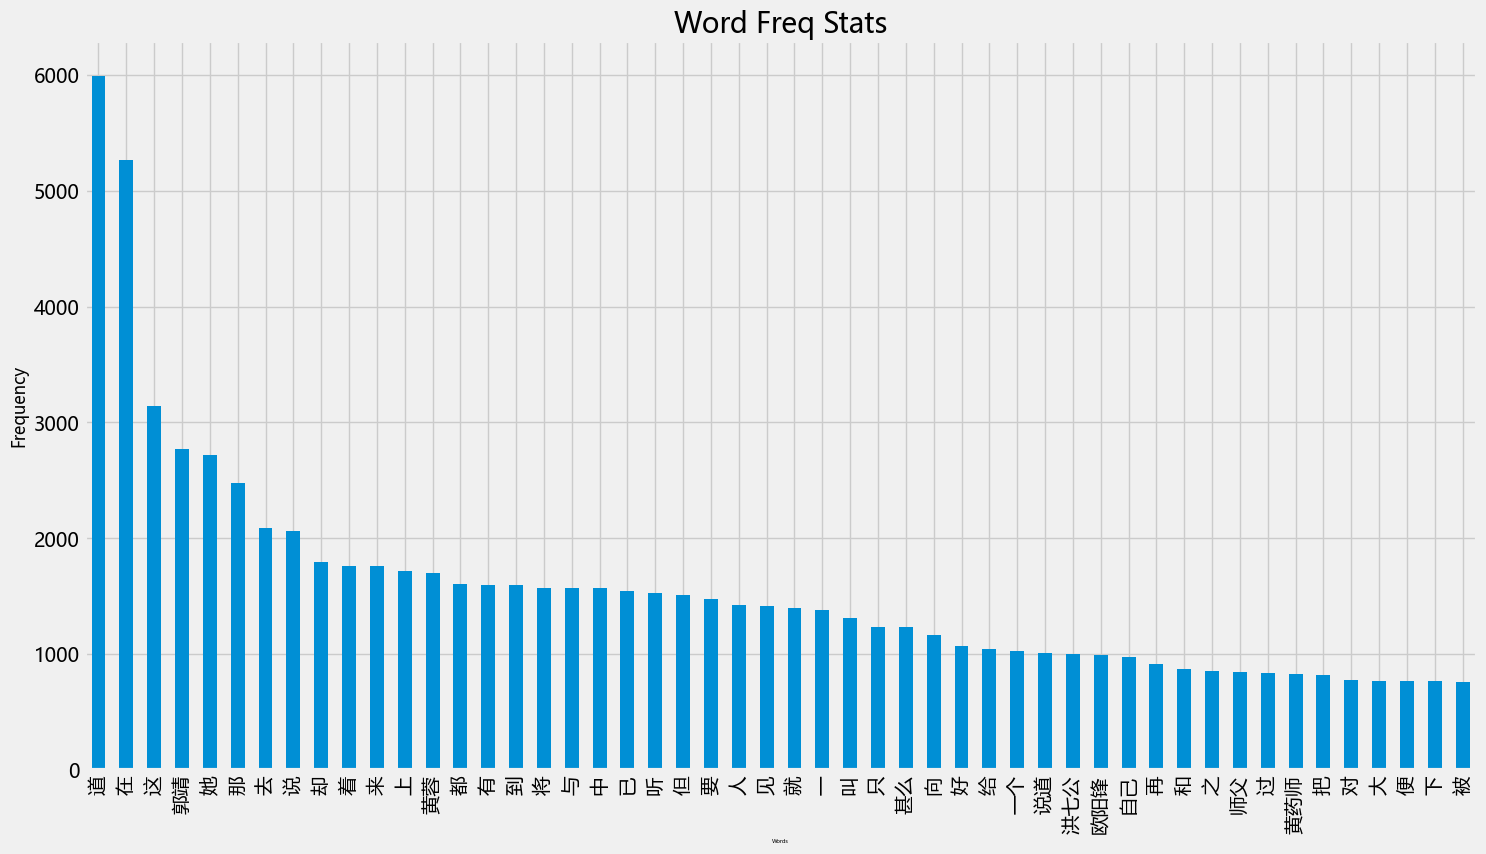

total valid words: 15880


In [12]:
plt.figure(figsize=(16, 9))
word_freq_df[:50]["freq"].plot(kind="bar")
plt.title('Word Freq Stats')
plt.xlabel('Words', fontsize=4)
plt.ylabel('Frequency', fontsize=12)
plt.show()

valid_words = set(word_freq_df.query("freq >= 3").index.to_list())
print(f"total valid words: {len(valid_words)}")

In [13]:
from gensim.models import Word2Vec
# train model

# 1. define model sg=1: skip-gram
model = Word2Vec(sg=1, window=10, vector_size=128, min_count=5, negative=10, workers=8)
# 2. build vocab
model.build_vocab(corpus, progress_per=10000)
# 3. train model
model.train(corpus, total_examples=model.corpus_count, epochs=30)

(9561838, 12191610)

In [14]:
word_vec = model.wv

print("--> print the top-k most-like words")
for sim_word in word_vec.most_similar(positive=["黄蓉"], topn=10):
    print(sim_word)

--> print the top-k most-like words
('郭靖', 0.738839864730835)
('她', 0.6311905980110168)
('却', 0.5692079663276672)
('芦管', 0.5274140238761902)
('刚要', 0.49575114250183105)
('步奔', 0.48929262161254883)
('黄蓉甚', 0.48736947774887085)
('半只', 0.47877633571624756)
('头去', 0.4659034013748169)
('前伸', 0.46360498666763306)


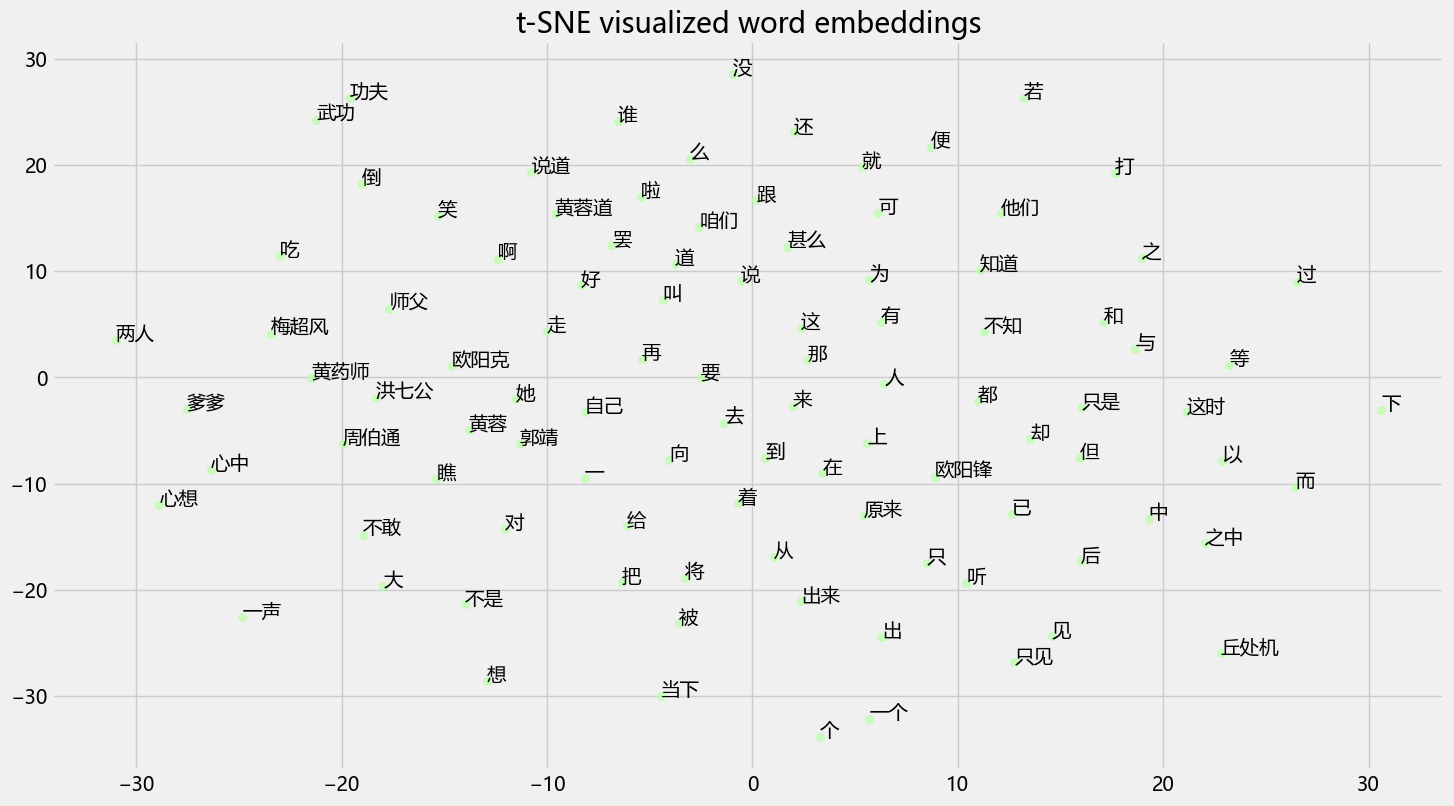

In [15]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

def reduce_dimensions(model, topn):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors[:topn])
    labels = np.asarray(model.wv.index_to_key[:topn])

    # apply TSNE
    tsne = TSNE(n_components=num_components, random_state=0, n_iter = 1000, metric = 'cosine')
    vectors = tsne.fit_transform(vectors)

    x_vals, y_vals = vectors[:, 0], vectors[:, 1]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.scatter(x=x_vals, y=y_vals, c='#bfa', alpha=.7)
    for i, txt in enumerate(labels):
        ax.annotate(txt, (x_vals[i], y_vals[i]))
    ax.set_title("t-SNE visualized word embeddings")
    # ax.legend()
    # ax.grid(False)
    plt.show()


x_vals, y_vals, labels = reduce_dimensions(model, 100)
plot = plot_embeddings(x_vals, y_vals, labels)

54 54 54


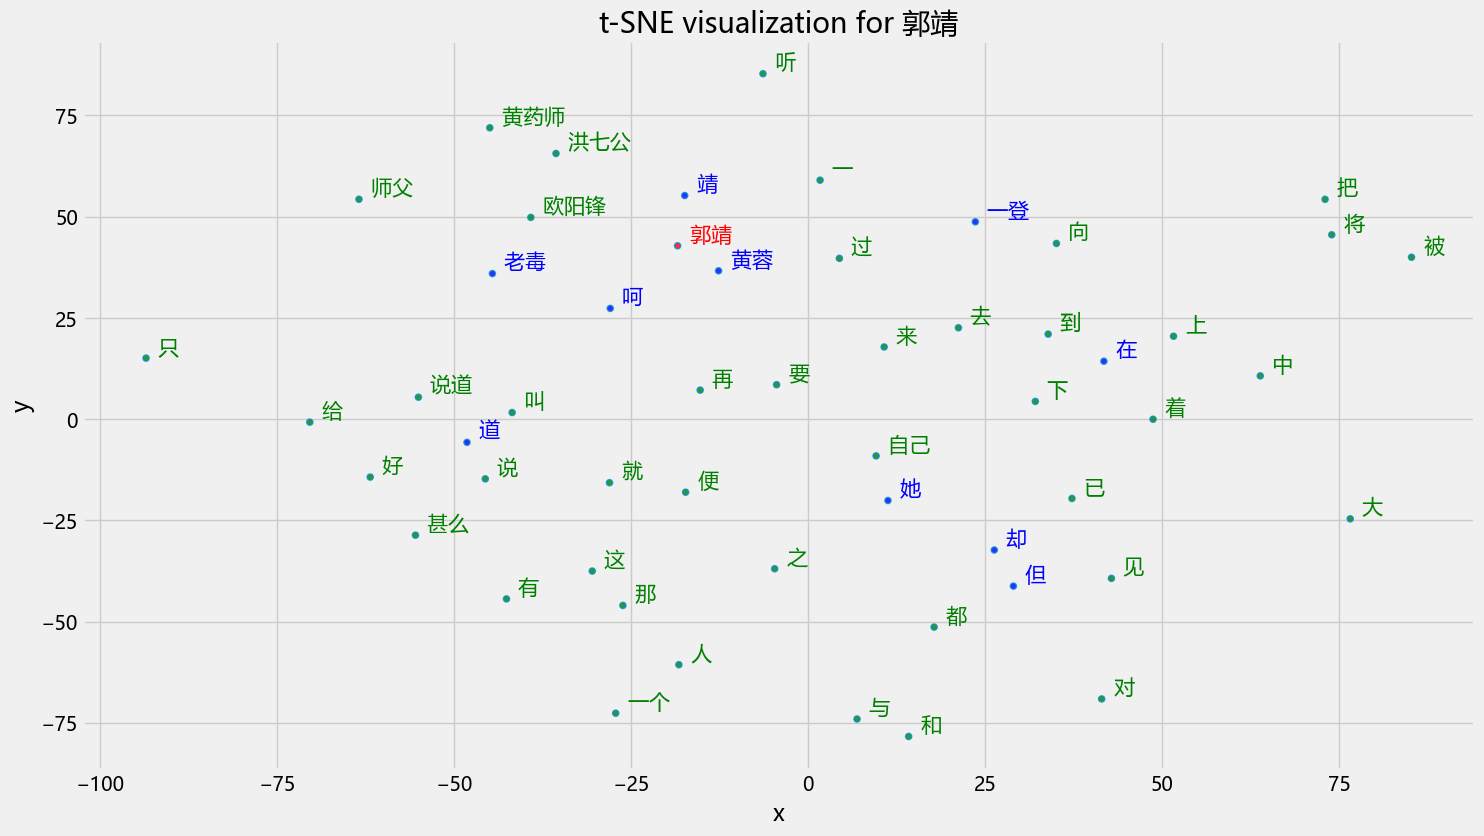

In [21]:
import pandas as pd

def tsne_scatter_plot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    wv = model.wv
    record_words = set()

    # arrays = np.empty((0, 16), dtype='f') # 2d array: [[word0_emb], [word1_emb], ...]
    embeddings = []
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    embeddings.append(wv.get_vector(word))
    record_words.add(word)

    # gets list of most similar words
    close_words = wv.most_similar(word, topn=10)

    # adds the vector for each of the closest words to the array
    for wd, score in close_words:
        embeddings.append(wv.get_vector(wd))
        record_words.add(wd)
        word_labels.append(wd)
        color_list.append('blue')

    # adds the vector for each of the words from list_names to the array
    for wd in wv.index_to_key[:50]:
        if wd in record_words:
            continue
        embeddings.append(wv.get_vector(wd))
        record_words.add(wd)
        word_labels.append(wd)
        color_list.append('green')

    # Reduces the dimensionality from 256 to 16 dimensions with PCA
    # reduc = PCA(n_components=16).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    tsne = TSNE(n_components=2, perplexity=8, random_state=0, n_iter = 1000, metric = 'cosine')
    Y = tsne.fit_transform(np.asarray(embeddings))
    print(len(Y), len(word_labels), len(color_list))
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots(figsize=(16,9))

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={
                            's': 20,
                            'facecolors': df['color']
                         }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    # plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    # plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word))

tsne_scatter_plot(model, "郭靖")